In [1]:
# 批量规范化
''' 
训练深层神经⽹络是⼗分困难的，特别是在较短的时间内使他们收敛更加棘⼿。在本节中，我们将介绍批量
规范化（batch normalization）[Ioffe & Szegedy, 2015]，这是⼀种流⾏且有效的技术，可持续加速深层⽹络
的收敛速度。再结合在 7.6节中将介绍的残差块，批量规范化使得研究⼈员能够训练100层以上的⽹络。
--------------------------------------------------------------------------------------------
训练深层⽹络:

批量规范化应⽤于单个可选层（也可以应⽤到所有层），其原理如下：在每次训练迭代中，我们⾸先规范化输
⼊，即通过减去其均值并除以其标准差，其中两者均基于当前⼩批量处理。接下来，我们应⽤⽐例系数和⽐
例偏移。正是由于这个基于批量统计的标准化，才有了批量规范化的名称。

请注意，如果我们尝试使⽤⼤⼩为1的⼩批量应⽤批量规范化，我们将⽆法学到任何东西。这是因为在减去均
值之后，每个隐藏单元将为0。所以，只有使⽤⾜够⼤的⼩批量，批量规范化这种⽅法才是有效且稳定的。请
注意，在应⽤批量规范化时，批量⼤⼩的选择可能⽐没有批量规范化时更重要。

由于在训练过程中，中间层的变化幅度不能过于剧烈，⽽批量规范化将每⼀层主动居中，并将它们重新调整
为给定的平均值和⼤⼩（通过ˆµB和ˆσB）

请注意，我们在⽅差估计值中添加⼀个⼩的常量ϵ > 0，以确保我们永远不会尝试除以零，即使在经验⽅差估
计值可能消失的情况下也是如此。估计值ˆµB和ˆσB通过使⽤平均值和⽅差的噪声（noise）估计来抵消缩放问
题。你可能会认为这种噪声是⼀个问题，⽽事实上它是有益的。

事实证明，这是深度学习中⼀个反复出现的主题。由于尚未在理论上明确的原因，优化中的各种噪声源通常会
导致更快的训练和较少的过拟合：这种变化似乎是正则化的⼀种形式。在⼀些初步研究中，[Teye et al., 2018]和
[Luo et al., 2018]分别将批量规范化的性质与⻉叶斯先验相关联。这些理论揭⽰了为什么批量规范化最适
应50 ∼ 100范围中的中等批量⼤⼩的难题

另外，批量规范化层在”训练模式“（通过⼩批量统计数据规范化）和“预测模式”（通过数据集统计规范化）
中的功能不同。在训练过程中，我们⽆法得知使⽤整个数据集来估计平均值和⽅差，所以只能根据每个⼩批
次的平均值和⽅差不断训练模型。⽽在预测模式下，可以根据整个数据集精确计算批量规范化所需的平均值
和⽅差 
----------------------------------------------------------------------------------------
# 批量规范化层:
回想⼀下，批量规范化和其他层之间的⼀个关键区别是，由于批量规范化在完整的⼩批量上运⾏，因此我们
不能像以前在引⼊其他层时那样忽略批量⼤⼩。我们在下⾯讨论这两种情况：全连接层和卷积层，他们的批
量规范化实现略有不同。

全连接层:
通常，我们将批量规范化层置于全连接层中的仿射变换和激活函数之间。设全连接层的输⼊为u，权重参数
和偏置参数分别为W和b，激活函数为ϕ，批量规范化的运算符为BN。那么，使⽤批量规范化的全连接层的输
出的计算详情如下： 
h = ϕ(BN(Wx + b))   (7.5.3)   # BN 批量规范化
回想⼀下，均值和⽅差是在应⽤变换的”相同”⼩批量上计算的。

卷积层:
同样，对于卷积层，我们可以在卷积层之后和⾮线性激活函数之前应⽤批量规范化。当卷积有多个输出通道
时，我们需要对这些通道的“每个”输出执⾏批量规范化，每个通道都有⾃⼰的拉伸（scale）和偏移（shift）
参数，这两个参数都是标量。假设我们的⼩批量包含m个样本，并且对于每个通道，卷积的输出具有⾼度p和
宽度q。那么对于卷积层，我们在每个输出通道的m · p · q个元素上同时执⾏每个批量规范化。因此，在计算
平均值和⽅差时，我们会收集所有空间位置的值，然后在给定通道内应⽤相同的均值和⽅差，以便在每个空
间位置对值进⾏规范化。

预测过程中的批量规范化:
正如我们前⾯提到的，批量规范化在训练模式和预测模式下的⾏为通常不同。⾸先，将训练好的模型⽤于预
测时，我们不再需要样本均值中的噪声以及在微批次上估计每个⼩批次产⽣的样本⽅差了。其次，例如，我
们可能需要使⽤我们的模型对逐个样本进⾏预测。⼀种常⽤的⽅法是通过移动平均估算整个训练数据集的样
本均值和⽅差，并在预测时使⽤它们得到确定的输出。可⻅，和暂退法⼀样，批量规范化层在训练模式和预
测模式下的计算结果也是不⼀样的。
'''
# 从头开始实现⼀个具有张量的批量规范化层
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
''' 
BN训练时为什么不用全量训练集的均值和方差呢？

因为在训练的第一个完整epoch过程中是无法得到输入层之外其他层全量训练集的均值和方差，
只能在前向传播过程中获取已训练batch的均值和方差。
--------------------------------------------------------------------------------------
那在一个完整epoch之后可以使用全量数据集的均值和方差嘛？

对于BN，是对每一批数据进行归一化到一个相同的分布，而每一批数据的均值和方差会有一定的差别，
而不是用固定的值，这个差别实际上也能够增加模型的鲁棒性，也会在一定程度上减少过拟合。
但是一批数据和全量数据的均值和方差相差太多，又无法较好地代表训练集的分布，
因此，BN一般要求将训练集完全打乱，并用一个较大的batch值，去缩小与全量数据的差别。
'''

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使⽤传⼊的移动平均所得的均值和⽅差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps) # 标准化,其中 eps 防止除0
    else: 
        #  训练模式
        assert len(X.shape) in (2, 4) # num_dims：2表⽰完全连接层，4表⽰卷积层
        if len(X.shape) == 2:
            # 使⽤全连接层的情况，计算特征维上的均值和⽅差
            mean = X.mean(dim=0) # dim=0,第0个维度,代表行 即跨行求平均
            var = ((X - mean) ** 2).mean(dim=0) # 方差
        else:
            # 使⽤⼆维卷积层的情况，计算通道维上（axis=1）的均值和⽅差。
            # 这⾥我们需要保持X的形状以便后⾯可以做⼴播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True) # 计算通道维上的均值
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True) # 方差
        # 训练模式下，⽤当前的均值和⽅差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps) # 标准化
        # 更新移动平均的均值和⽅差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean # momentum 动量参数
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta # 对X__hat进行缩放和移位
    return Y, moving_mean.data, moving_var.data

In [3]:
''' 
我们现在可以创建⼀个正确的BatchNorm层。这个层将保持适当的参数：拉伸gamma和偏移beta,这两个参
数将在训练过程中更新。此外，我们的层将保存均值和⽅差的移动平均值，以便在模型预测期间随后使⽤。

撇开算法细节，注意我们实现层的基础设计模式。通常情况下，我们⽤⼀个单独的函数定义其数学原理，⽐如
说batch_norm。然后，我们将此功能集成到⼀个⾃定义层中，其代码主要处理数据移动到训练设备（如GPU）、
分配和初始化任何必需的变量、跟踪移动平均线（此处为均值和⽅差）等问题。为了⽅便起⻅，我们并不担
⼼在这⾥⾃动推断输⼊形状，因此我们需要指定整个特征的数量。不⽤担⼼，深度学习框架中的批量规范
化API将为我们解决上述问题，我们稍后将展⽰这⼀点。
'''
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表⽰完全连接层，4表⽰卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2: # 全连接层
            shape = (1, num_features) # 用于构建 gamma 与 beta 的形状
        else: # 卷积层
            shape = (1, num_features, 1, 1) 
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape)) # 用于缩放 X_hat (标准化后的X)
        self.beta = nn.Parameter(torch.zeros(shape))
        # ⾮模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        # batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [7]:
''' 
使⽤批量规范化层的 LeNet
为了更好理解如何应⽤BatchNorm，下⾯我们将其应⽤于LeNet模型（6.6节）。回想⼀下，批量规范化是在
卷积层或全连接层之后、相应的激活函数之前应⽤的
# BatchNorm(6, num_dims=4) 卷积层的输出通道数 6   四维特征 num_dims=4
# 全连接层的输出通道数 num_dims=2
'''
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.262, train acc 0.904, test acc 0.841
35107.5 examples/sec on cuda:0


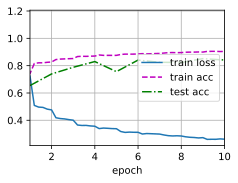

In [8]:
''' 
和以前⼀样，我们将在Fashion-MNIST数据集上训练⽹络。这个代码与我们第⼀次训练LeNet（6.6节）时⼏
乎完全相同，主要区别在于学习率⼤得多。
'''
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [9]:
# 让我们来看看从第⼀个批量规范化层中学到的拉伸参数gamma和偏移参数beta。
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.7612, 3.1677, 2.9040, 0.9846, 2.5039, 3.7773], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 0.5909,  2.1850,  3.0494,  0.4383, -1.6319, -2.2558], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

In [ ]:
''' 
简明实现
除了使⽤我们刚刚定义的BatchNorm，我们也可以直接使⽤深度学习框架中定义的BatchNorm。该代码看
起来⼏乎与我们上⾯的代码相同。

nn.BatchNorm2d(6) 卷积层/全连接层的输出通道数
'''
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.252, train acc 0.906, test acc 0.853
35111.7 examples/sec on cuda:0


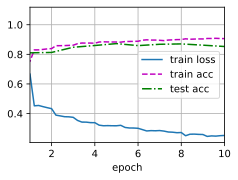

In [10]:
''' 
下⾯，我们使⽤相同超参数来训练模型。请注意，通常⾼级API变体运⾏速度快得多，因为它的代码已编译
为C++或CUDA，⽽我们的⾃定义代码由Python实现。

学习率,训练周期,批量大小已定义:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
'''
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
''' 
争议:

直观地说，批量规范化被认为可以使优化更加平滑。然⽽，我们必须⼩⼼区分直觉和对我们观察到的现象的
真实解释。回想⼀下，我们甚⾄不知道简单的神经⽹络（多层感知机和传统的卷积神经⽹络）为什么如此有
效。即使在暂退法和权重衰减的情况下，它们仍然⾮常灵活，因此⽆法通过常规的学习理论泛化保证来解释
它们是否能够泛化到看不⻅的数据。

在提出批量规范化的论⽂中，作者除了介绍了其应⽤，还解释了其原理：通过减少内部协变量偏移（internal
covariate shift）。据推测，作者所说的“内部协变量转移”类似于上述的投机直觉，即变量值的分布在训练
过程中会发⽣变化。然⽽，这种解释有两个问题：1、这种偏移与严格定义的协变量偏移（covariate shift）⾮
常不同，所以这个名字⽤词不当。2、这种解释只提供了⼀种不明确的直觉，但留下了⼀个有待后续挖掘的问
题：为什么这项技术如此有效？本书旨在传达实践者⽤来发展深层神经⽹络的直觉。然⽽，重要的是将这些
指导性直觉与既定的科学事实区分开来。最终，当你掌握了这些⽅法，并开始撰写⾃⼰的研究论⽂时，你会
希望清楚地区分技术和直觉。

随着批量规范化的普及，“内部协变量偏移”的解释反复出现在技术⽂献的辩论，特别是关于“如何展⽰机器学
习研究”的更⼴泛的讨论中。Ali Rahimi在接受2017年NeurIPS⼤会的“接受时间考验奖”(Test of Time Award)
时发表了⼀篇令⼈难忘的演讲。他将“内部协变量转移”作为焦点，将现代深度学习的实践⽐作炼⾦术。他对
该⽰例进⾏了详细回顾 [Lipton & Steinhardt, 2018]，概述了机器学习中令⼈不安的趋势。此外，⼀些作者对批
量规范化的成功提出了另⼀种解释：在某些⽅⾯，批量规范化的表现出与原始论⽂ [Santurkar et al., 2018]中
声称的⾏为是相反的。

然⽽，与机器学习⽂献中成千上万类似模糊的说法相⽐，内部协变量偏移没有更值得批评。很可能，它作为
这些辩论的焦点⽽产⽣共鸣，要归功于⽬标受众对它的⼴泛认可。批量规范化已经被证明是⼀种不可或缺的
⽅法。它适⽤于⼏乎所有图像分类器，并在学术界获得了数万引⽤。
-------------------------------------------------------------------------------------
⼩结
• 在模型训练过程中，批量规范化利⽤⼩批量的均值和标准差，不断调整神经⽹络的中间输出，使整个神
经⽹络各层的中间输出值更加稳定。
• 批量规范化在全连接层和卷积层的使⽤略有不同。
• 批量规范化层和暂退层⼀样，在训练模式和预测模式下计算不同。
• 批量规范化有许多有益的副作⽤，主要是正则化。另⼀⽅⾯，”减少内部协变量偏移“的原始动机似乎
不是⼀个有效的解释。
'''